# Preâmbulo

In [30]:
# Biblioteca para utilizar na regressão simbólica
#!pip install itea

In [31]:
# Bibliotecas básicas
import pandas as pd
import numpy as np

# Geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para o aprendizado de máquina
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from itea.regression import ITEA_regressor
from itea.inspection import *

# Carregamento do Dataset

In [32]:
dataset = pd.read_csv('APS.csv')

# Pré-processamento

In [33]:
# Remove regitros incorretos do dataset
df_remove = dataset.loc[(dataset['y1'] < 1893) | (dataset['y2'] > 2018)]
dataset = dataset.drop(df_remove.index)

# Criação de uma nova feature que mostra a diferença entre o ano da primeira e da última publicação na base de dados
dataset['y2y1_dif'] = dataset['y2'] - dataset['y1']

# Remoção de features não necessárias
dt = dataset.drop(columns=['name','y1','y2','h_future_3','i4_future_3','i5_future_3'])

In [34]:
X = dt.drop(columns=['i3_future_3'])
y = np.ravel(pd.DataFrame(dt, columns=['i3_future_3']).to_numpy())

labels = X.columns

In [35]:
# Normalização
escala = StandardScaler()
escala.fit(X)
X = escala.transform(X)

In [36]:
# Dividindo o conjunto em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.3, random_state=39)

# Processamento

In [37]:
#define as funções que serão usadas e suas respectivas derivadas

tfuncs = {
    'log'      : np.log,
    'sqrt.abs' : lambda x: np.sqrt(np.abs(x)),
    'id'       : lambda x: x,
    'exp'      : np.exp,
}

tfuncs_dx = {
    'log'      : lambda x: 1/x,
    'sqrt.abs' : lambda x: x/( 2*(np.abs(x)**(3/2)) ),
    'id'       : lambda x: np.ones_like(x),
    'exp'      : np.exp,
}

In [49]:
#treinamento itea
reg = ITEA_regressor(
    gens         = 900,
    popsize      = 15,
    max_terms    = 7,
    fitness_f    ='rmse',
    expolim      = (0, 2),
    verbose      = 10,
    tfuncs       = tfuncs,
    tfuncs_dx    = tfuncs_dx,
    labels       = labels,
    random_state = 39,
    simplify_method = 'simplify_by_coef'
).fit(X_train, y_train)

gen | smallest fitness | mean fitness | highest fitness | remaining time
----------------------------------------------------------------------------
  0 |         1.598982 |          inf |             inf | 11min15sec  
 10 |         1.390411 |     1.435749 |        1.502678 | 22min22sec  
 20 |         1.360056 |     1.377135 |        1.390411 | 28min51sec  
 30 |         1.342124 |     1.357108 |        1.362556 | 41min39sec  
 40 |         1.318912 |     1.331036 |        1.342124 | 44min58sec  
 50 |         1.305002 |     1.318317 |        1.333909 | 34min17sec  
 60 |         1.298354 |     1.305171 |        1.333754 | 34min5sec   
 70 |         1.294915 |     1.301414 |        1.317352 | 39min31sec  
 80 |         1.294226 |     1.299683 |        1.317352 | 34min47sec  
 90 |         1.292388 |     1.299975 |        1.315044 | 37min5sec   
100 |         1.277602 |     1.279494 |        1.279881 | 30min11sec  
110 |         1.276531 |     1.279526 |        1.293546 | 32min41sec 

# Pós-processamento

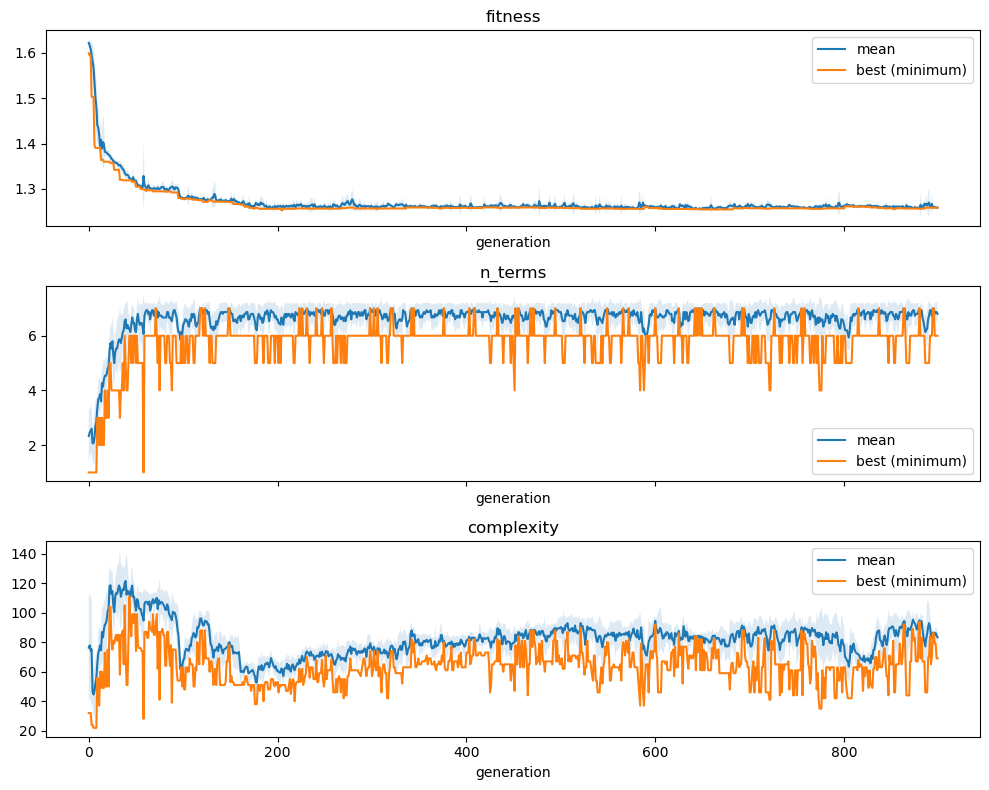

In [50]:
#inspecionando os resultados

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

summarizer = ITEA_summarizer(itea=reg).fit(X_train, y_train)

summarizer.plot_convergence(
    data=['fitness', 'n_terms', 'complexity'],
    ax=axs,
    show=False
)

plt.tight_layout()
plt.show()

In [51]:
final_itexpr = reg.bestsol_

print('\nFinal expression:\n', final_itexpr.to_str(term_separator=' +\n'))
print(f'\nElapsed time: {reg.exectime_}')
print(f'\nSelected Features: {final_itexpr.selected_features_}')


Final expression:
 -0.566*sqrt.abs(i_5_5^2) +
0.089*sqrt.abs(co * co_5^2 * c_3) +
-0.114*sqrt.abs(co_5^2 * h_5 * h_3 * co_53) +
0.0*sqrt.abs(h * h_5^2 * c * c_3^2 * i_10_5 * co_51^2 * co_52) +
0.615*sqrt.abs(h_5 * co_53^2) +
2.624*sqrt.abs(i_5_5) +
0.001*sqrt.abs(co * co_5^2 * h_5 * c_3 * co_53^2) +
-1.145

Elapsed time: 2576.1187999248505

Selected Features: ['co' 'co_5' 'h' 'h_5' 'h_3' 'c' 'c_3' 'i_10_5' 'i_5_5' 'v_5' 'p_5' 'p_3']


In [52]:
#X = escala.inverse_transform(X)

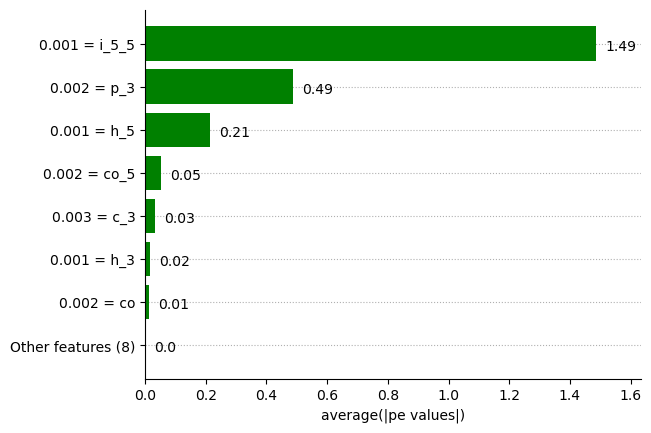

In [53]:
# Importância de cada feature

explainer = ITExpr_explainer(
    itexpr=final_itexpr, tfuncs=tfuncs, tfuncs_dx=tfuncs_dx).fit(X, y)

explainer.plot_feature_importances(
    X=X_train,
    importance_method='pe',
    grouping_threshold=0.001,
    barh_kw={'color':'green'}
)

C:\Users\UFMA\anaconda3\Lib\site-packages\itea\inspection\_ITExpr_explainer.py:991: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axi.set_ylim((ymin*0.99, ymax*1.01))


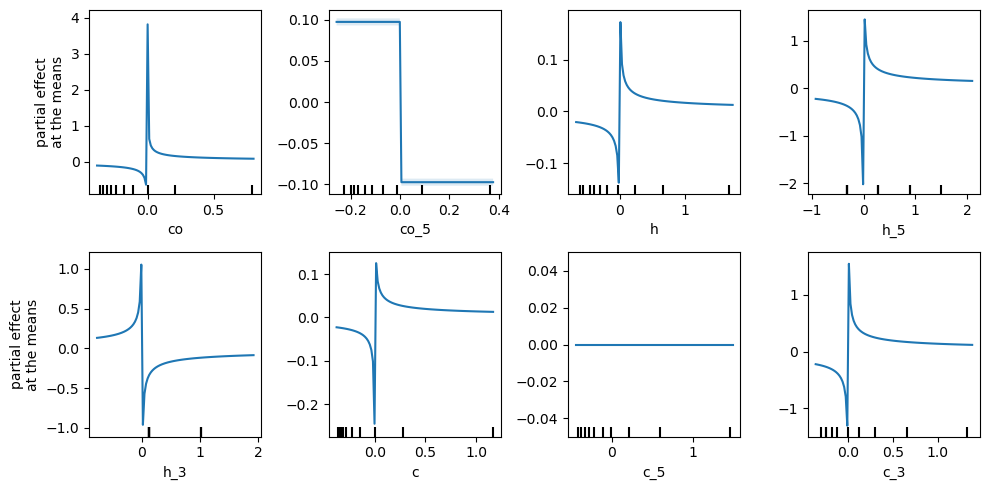

In [54]:
# efeitos parciais de cada feature na média

fig, axs = plt.subplots(2, 4, figsize=(10, 5))

explainer.plot_partial_effects_at_means(
    X=X_test,
    features=range(8),
    ax=axs,
    num_points=100,
    share_y=False,
    show_err=True,
    show=False
)

plt.tight_layout()
plt.show()

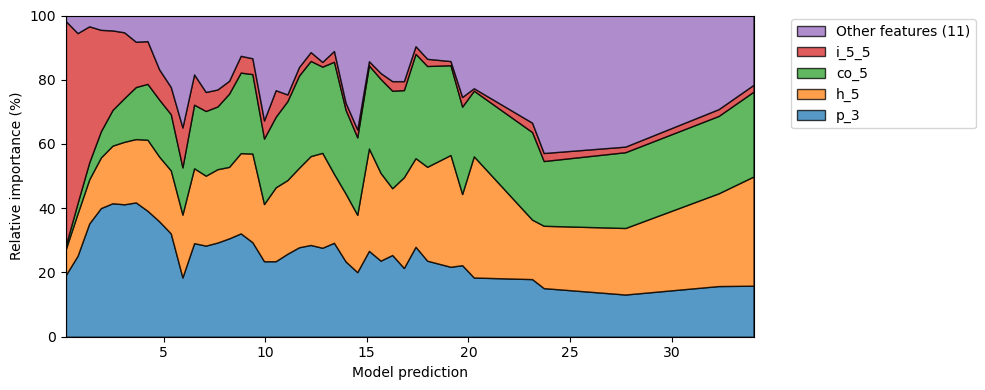

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

explainer.plot_normalized_partial_effects(
    grouping_threshold=0.1, show=False,
    num_points=100, ax=ax
)

plt.tight_layout()

In [63]:
# Métricas
y_pred = final_itexpr.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared = False))
print("R2:",r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

#y_pred = np.around(y_pred,0).astype(int)
#np.savetxt('SR_y_pred.csv', y_pred, delimiter=',', header='SR_y_pred')

RMSE: 1.2417911382187705
R2: 0.45927446915105374
MAE: 0.7911414384937073


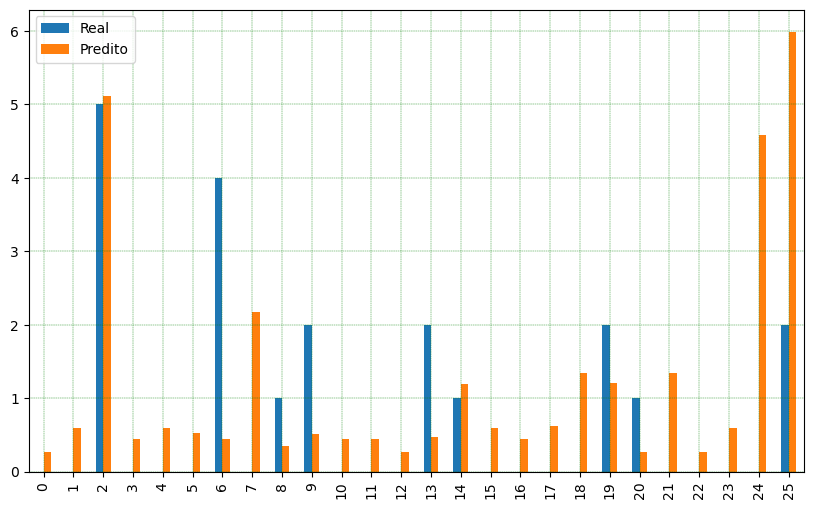

In [64]:
df_temp = pd.DataFrame({'Real': y_test, 'Predito': y_pred})
df_temp.head()
df_temp = df_temp.head(26)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='--', linewidth='0.3', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.show()

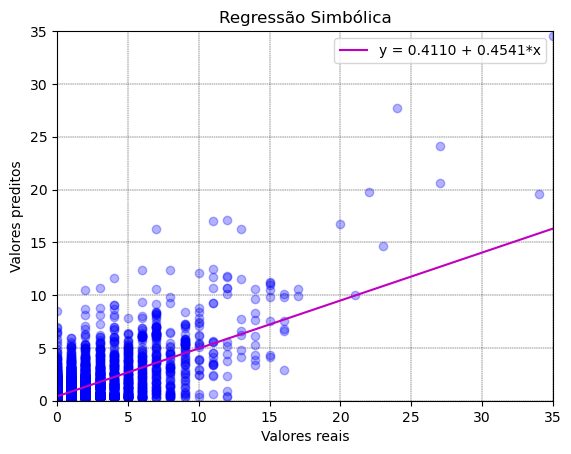

In [65]:
# Regressão Linear usando os dados de teste e preditos
lr=LinearRegression().fit(y_test.reshape(-1, 1),y_pred.reshape(-1, 1))
a,b = float(lr.coef_[0]), float(lr.intercept_[0])
x = np.linspace(0,90)

plt.title('Regressão Simbólica')
plt.xlabel('Valores reais')
plt.ylabel('Valores preditos')
plt.xlim(0, 35)
plt.ylim(0, 35)

plt.plot(x , (b + a*x),'m', label = 'y = {:.4f} + {:.4f}*x'.format(b,a))
plt.scatter(y_test, y_pred, c='b', marker='o', alpha=0.3)

plt.grid(linestyle='--', linewidth='0.3', color='black')
plt.legend(loc='best')
plt.savefig('SR_model.png',dpi=600)
plt.show()

In [66]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression().fit(y_test.reshape(-1, 1),y_pred.reshape(-1, 1))
print(f'Parâmetros: intercept: {lr.intercept_}, coef: {lr.coef_}')

Parâmetros: intercept: [0.41099391], coef: [[0.4540514]]
